# Plotting Principal Components

## Below Is a one-cell operation that loads, cleans, reshapes, filters, imputes, and runs the data
> ### This is therefore a ***brief*** insight into the grander scope of the project
> ### Please note that all visualizations are *NOT* final

### What is happening?
- libraries are imported
- the data is loaded and preprocessed
- It is cleaned and shaped in a variety of ways
- null values are located
- features with too many null values are filtered
- remaining null values are imputed using [MICE imputation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)
- data is reshaped again
- Scikit's `MinMax Scaler` is applied [(as opposed to `Standard Scaler`)](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)
> - More on [why I chose MinMax](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02) from a fellow *Towards Data Science* author
- A Principal Component Analysis (PCA) is conducted on the imputed and scaled data
> - this is done for both the features and countries
- ***Why the countries?***
>- Please see [this paper](http://ranger.uta.edu/~chqding/papers/KmeansPCA1.pdf) which reflects on the similarities between K-means and PCA
> - Note that I still intend to apply K-means soon 
- Once PCA is applied, some very minor visualizations are provided
- As this is still very much within the middle of the process, I hesitate to describe conclusions just yet...

*However*, we know the correlations are being conducted properly from even minor glances at the Mapping, wherein Logistics Performance Index, or Export/Import features, are highly correlated not only clustered togther along the same principal components, but with other features of the same indication.

Furthermore, the same can be said for the countries and their relation to Tech (i.e. Japan and United States).

In [75]:
# Pandas and Numpy Libraries
import pandas as pd
import numpy as np

# Import Matplot Library
#%matplotlib notebook to make interactive within same window as JN
#%matplotlib
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# SciKit Learn Library
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Plotly Library 
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
import scipy as sci
import statsmodels as stats

# Experimental Libraries
from impyute.imputation.cs import mice
from collections import Counter

# Jupyter Display Settings
import warnings  
#Suppression of warnings (if not completed earlier):
#ignore permanently:
#warnings.filterwarnings('ignore')
#reset wanrnings:
#warnings.resetwarnings()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format



#######################
###  Entire Process ###
#######################
WorldData = pd.read_csv("WorldMarketData.csv", na_values = '..')
df_original = pd.DataFrame(WorldData)
df_original.columns = ['country', 'country_code', 'series', 'series_code', '1994', '1995', '1996', '1997',
                       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
                       '2007', '2008', '2009','2010', '2011', '2012', '2013', '2014', '2015', 
                       '2016', '2017', '2018']

df = df_original.drop(columns=['country_code', 'series_code'])
df = df.drop(df.index[3800:])
df1 = pd.melt(df,["country", 'series'],var_name="year",value_name="value")
#df1 = df1.sort_values(by=["year"], ascending = True)
df1 = df1.set_index('country').drop(index = ['World', 'Low income', 'Middle income', 'High income'])
df1 = df1.reset_index()
df1['year'] = df1['year'].astype(int)
df1.head()

df_stack = df1.set_index(['series', 'country'])
df_stack_all = df_stack
dfsa = df_stack_all.reset_index()
dfsa = dfsa.pivot_table(index = ['country', 'year'], columns = 'series', values='value', dropna=False)
dfsa = dfsa.reset_index()
#Filter the series that have less than 1000 entries
dfsa = dfsa.dropna(thresh=len(dfsa) - 1000, axis=1)
dfsa.head()

#Reshape
df2 = pd.melt(dfsa,["country", 'year'],var_name="series",value_name="value")
df2 = df2.pivot_table(index = ['country','series'], columns = 'year', values='value', dropna = False)

#Filter
m = df2.notna().sum(1).groupby(level=1).transform(lambda x: x.ge(1).all())
df2 = df2[m]
#Reset Shape
df2 = df2.reset_index()
df2 = pd.melt(df2,["country", 'series'],var_name="year",value_name="value")
df2.head(5)
#Set 'year' to Float so that `mice` can be applied
df2['year'] = df2['year'].astype(float)

#Group df2 by country-series pairs
dfgrp = df2.groupby(['country', 'series']) 

#Create a blank dataframe for the imputed data
ImpData = pd.DataFrame([])

#call the group in a for-loop
for dfgrp_index, group in dfgrp:

        #if any values within the group are null then proceed
        if group.isnull().values.any() == True:
            
            #Apply the imputation to the group's values
            group['value'] = ((mice(group.apply({'year': lambda x: x.values, 
                                                 'value': lambda y: y.values})))[1]).values
            
            #Append the imputed group to the ImpData dataframe
            ImpData = ImpData.append(pd.DataFrame({'country': group.country.values, 'series': group.series.values, 
                                                   'year': group.year.values, 'value': group.value.values}))
                
        #if no values in the group are null then append the groups values to the ImpData dataframe        
        else:
            
            ImpData = ImpData.append(pd.DataFrame({'country': group.country.values, 'series': group.series.values, 
                                                   'year': group.year.values, 'value': group.value.values}))
            
            #Advance to the next group
            continue

#Reset the index of the dataframe after everything has been filled
ImpData = ImpData.reset_index()
#drop the created 'index' column (these two steps are unnecessary, but resetting the index is just a precaution)
ImpData = ImpData.drop(columns = ['index'])

#Change years back to Int from Float64 for readability
ImpData['year'] = ImpData['year'].astype(int)
#Display the total null values within the dataframe (should be 0)
ImpData.isnull().sum().sum() 
#Copy to new df for easier access
imp_df = ImpData.copy()
imp_df.head()

#Countries and Series pivots
countries_pivoted = imp_df.pivot_table(index = ['series', 'year'], columns = 'country', values = 'value')
countries_pivoted.head(3)
series_pivoted = imp_df.pivot_table(index = ['country', 'year'], columns = 'series', values= 'value')
series_pivoted.head(100)

series          Cost of business start-up procedures (% of GNI per capita)  \
country   year                                                               
Argentina 1994                                              20.39            
          1995                                              20.05            
          1996                                              19.71            
          1997                                              19.38            
          1998                                              19.04            
          1999                                              18.70            
          2000                                              18.36            
          2001                                              18.03            
          2002                                              17.69            
          2003                                              13.50            
          2004                                              17.30            
          2005                                              15.90            
          2006                                              15.40            
          2007                                              13.60            
          2008                                              12.80            
          2009                                              16.10            
          2010                                              20.70            
          2011                                              17.70            
          2012                                              15.40            
          2013                                              23.20            
          2014                                              17.70            
          2015                                              11.40            
          2016                                              10.80            
          2017                                              10.40            
          2018                                               5.30            
Australia 1994                                               2.54            
          1995                                               2.45            
          1996                                               2.36            
          1997                                               2.27            
          1998                                               2.18            
...                                                           ...            
Bahrain   2014                                               0.80            
          2015                                               0.80            
          2016                                               1.20            
          2017                                               1.00            
          2018                                               1.10            
Belgium   1994                                              12.29            
          1995                                              11.94            
          1996                                              11.59            
          1997                                              11.24            
          1998                                              10.89            
          1999                                              10.54            
          2000                                              10.19            
          2001                                               9.84            
          2002                                               9.49            
          2003                                              11.10            
          2004                                              11.30            
          2005                                              11.10            
          2006                                               5.80            
          2007        

> ### The first 100 rows of the multi-indexed, cleaned, imputed, and country-pivoted data

# Countries Evaluation

Number of principal components:
2
Variance explained with each PC:
[0.91064076 0.04278291]
PCA array values:
[[-0.34275936 -0.01998597]
 [-0.34275936 -0.01998597]
 [-0.34275936 -0.01998597]
 ...
 [-0.34275936 -0.01998596]
 [-0.34275936 -0.01998596]
 [-0.34275936 -0.01998596]]


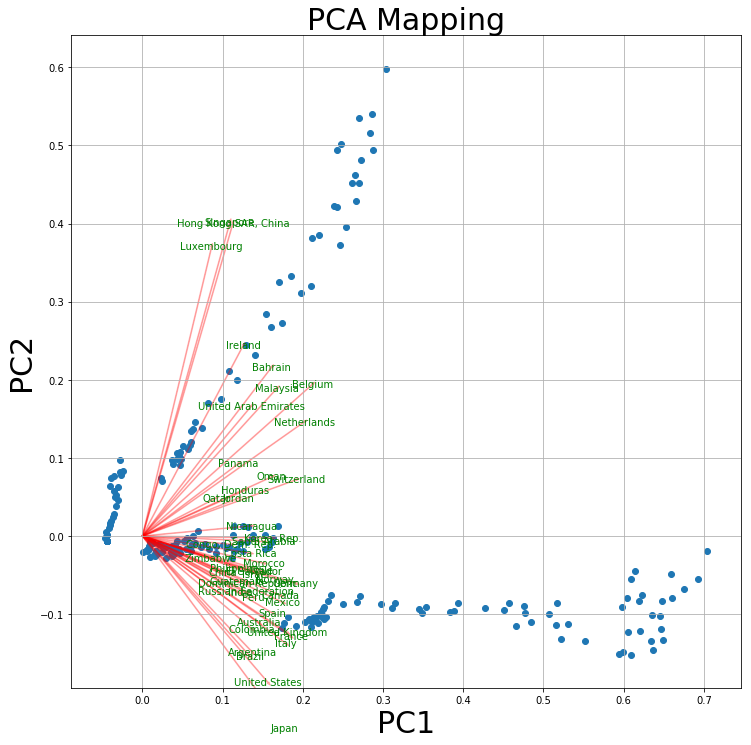

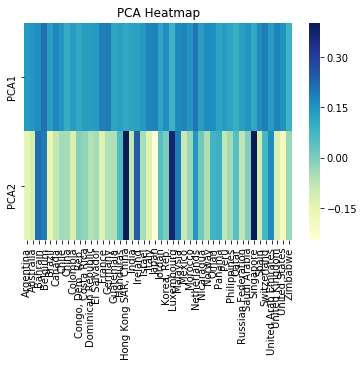

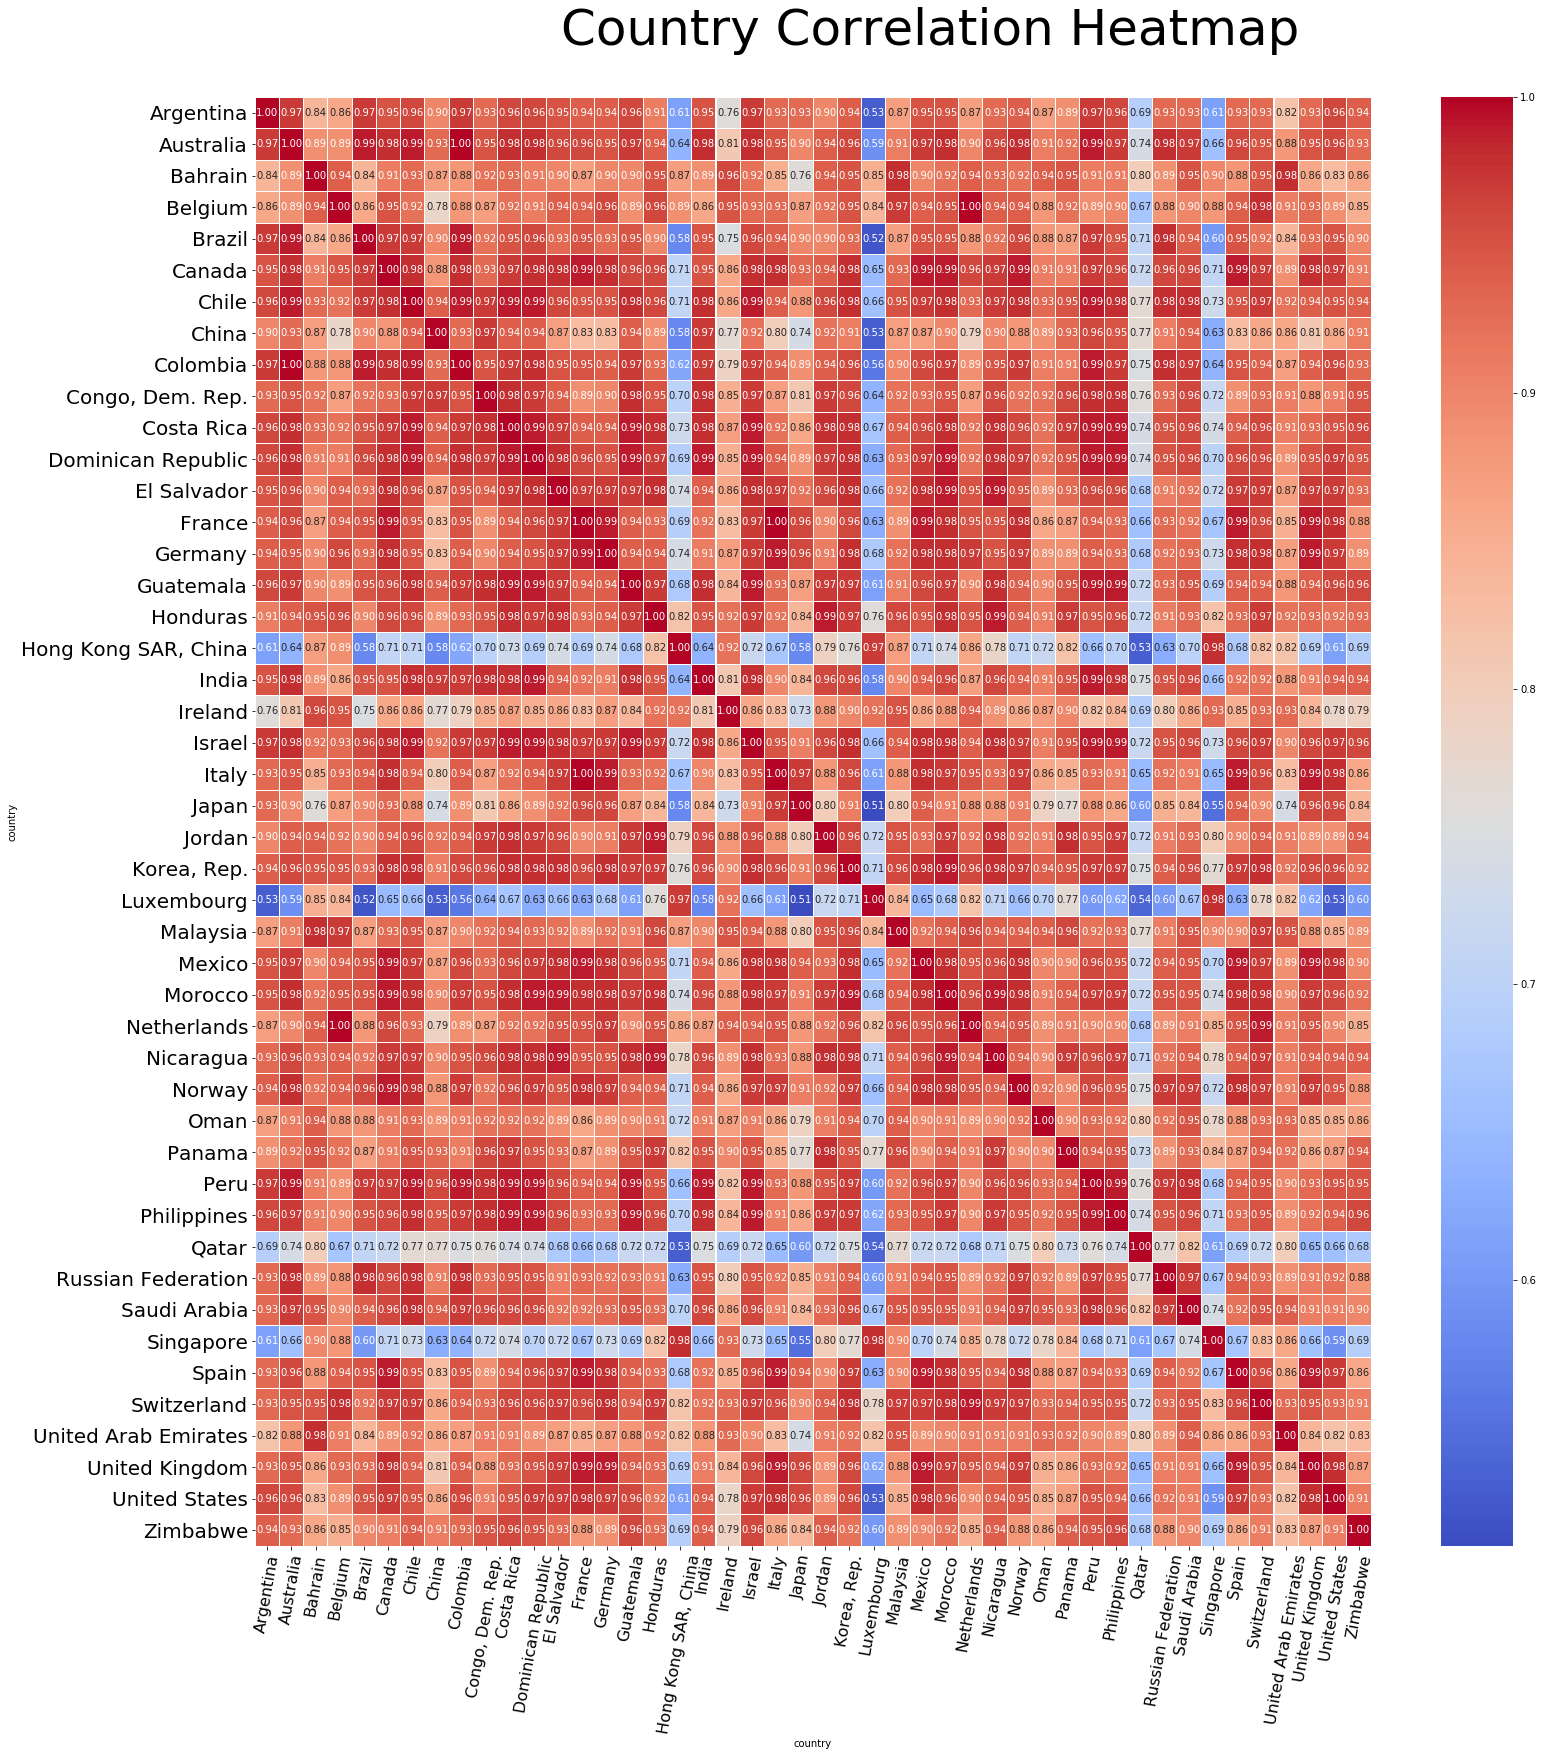

In [76]:
#The same Scaling, but with countries pivoted as opposed to the series
#Why?  Because this would allow for correlation between countries instead of the series/features
min_max_scaler = preprocessing.MinMaxScaler()

unscaled_values_array = countries_pivoted.values
scaled_values = min_max_scaler.fit_transform(unscaled_values_array)
x = scaled_values

scaled_pivot_df = pd.DataFrame(scaled_values, columns = countries_pivoted.columns, index = countries_pivoted.index)

pca_model = PCA(.95)

#Get an array of the PCA values
pca_values = pca_model.fit_transform(scaled_values)

#Show number of components
print('Number of principal components:')
print(pca_model.n_components_)

#Show how much variance is explained with each PC
print('Variance explained with each PC:')
print(pca_model.explained_variance_ratio_)

#Show values array
print('PCA array values:')
print(pca_values)


pca_dataframe = pd.DataFrame(x, columns=countries_pivoted.columns)



#PCA Biplot
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = .75/(xs.max() - xs.min())
    scaley = .75/(ys.max() - ys.min())
    plt.figure(figsize=(12,12))
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        #Where to start arrows, format arrows
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.25)
        if labels is None:
            plt.text(coeff[i,0]* 1, coeff[i,1] * 1, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1, coeff[i,1] * 1, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlabel("PC{}".format(1),fontsize = 30)
    plt.ylabel("PC{}".format(2),fontsize = 30)
    plt.title('PCA Mapping',fontsize = 30)
    plt.grid()

biplot(pca_values[:,0:2],np.transpose(pca_model.components_[0:2, :]),list(pca_dataframe.columns))
plt.show()

#small PCA Heatmap
ax = sns.heatmap(pca_model.components_, cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca_model.n_components_+1)],
                 xticklabels=list(pca_dataframe.columns),
                 cbar_kws={"orientation": "vertical"})
plt.title('PCA Heatmap')
plt.xticks(fontsize = 10)
ax.set_aspect("auto")



#Large Country Heatmap
fig, ax = plt.subplots(figsize=(25, 25))
corr = scaled_pivot_df.corr()
heat_map = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
plt.yticks(fontsize = 20)
plt.xticks(rotation = 80, fontsize = 16)
fig.subplots_adjust(top=0.93)
t= fig.suptitle('Country Correlation Heatmap', fontsize=50)

# Series/Feature Evaluation

Number of principal components:
6
Variance explained with each PC:
[0.40463016 0.12714877 0.0973351  0.06617946 0.04867599 0.03385499]
PCA array values:
[[ 0.41515204  0.18527746 -0.00977374 -0.45162453 -0.05342213  0.33430201]
 [ 0.38779268  0.18009886 -0.01130368 -0.44094412 -0.12298108  0.25875572]
 [ 0.41010554  0.17074282 -0.01715492 -0.42681268 -0.04403387  0.31205479]
 ...
 [ 1.0243956  -0.09272687 -0.1122392   0.16571108 -0.11434468  0.10401213]
 [ 0.90369726 -0.08608846 -0.10413921  0.1794263  -0.11568044  0.0815043 ]
 [ 0.89687314 -0.11293076 -0.12700146  0.24437263 -0.10204664  0.10686364]]


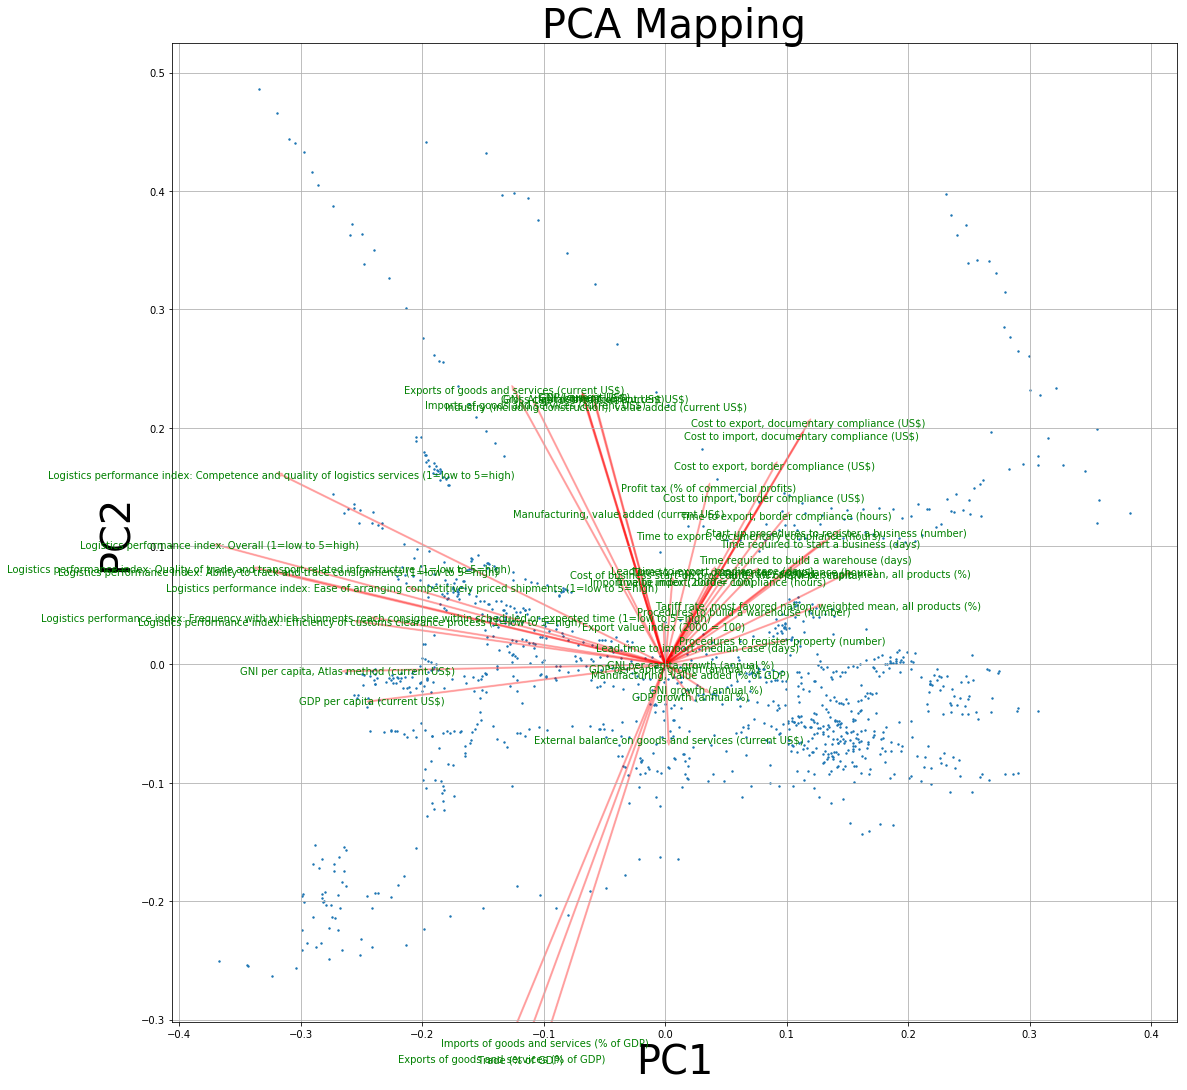

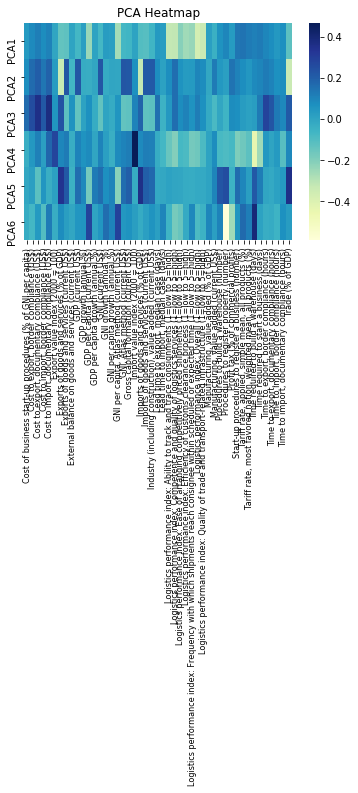

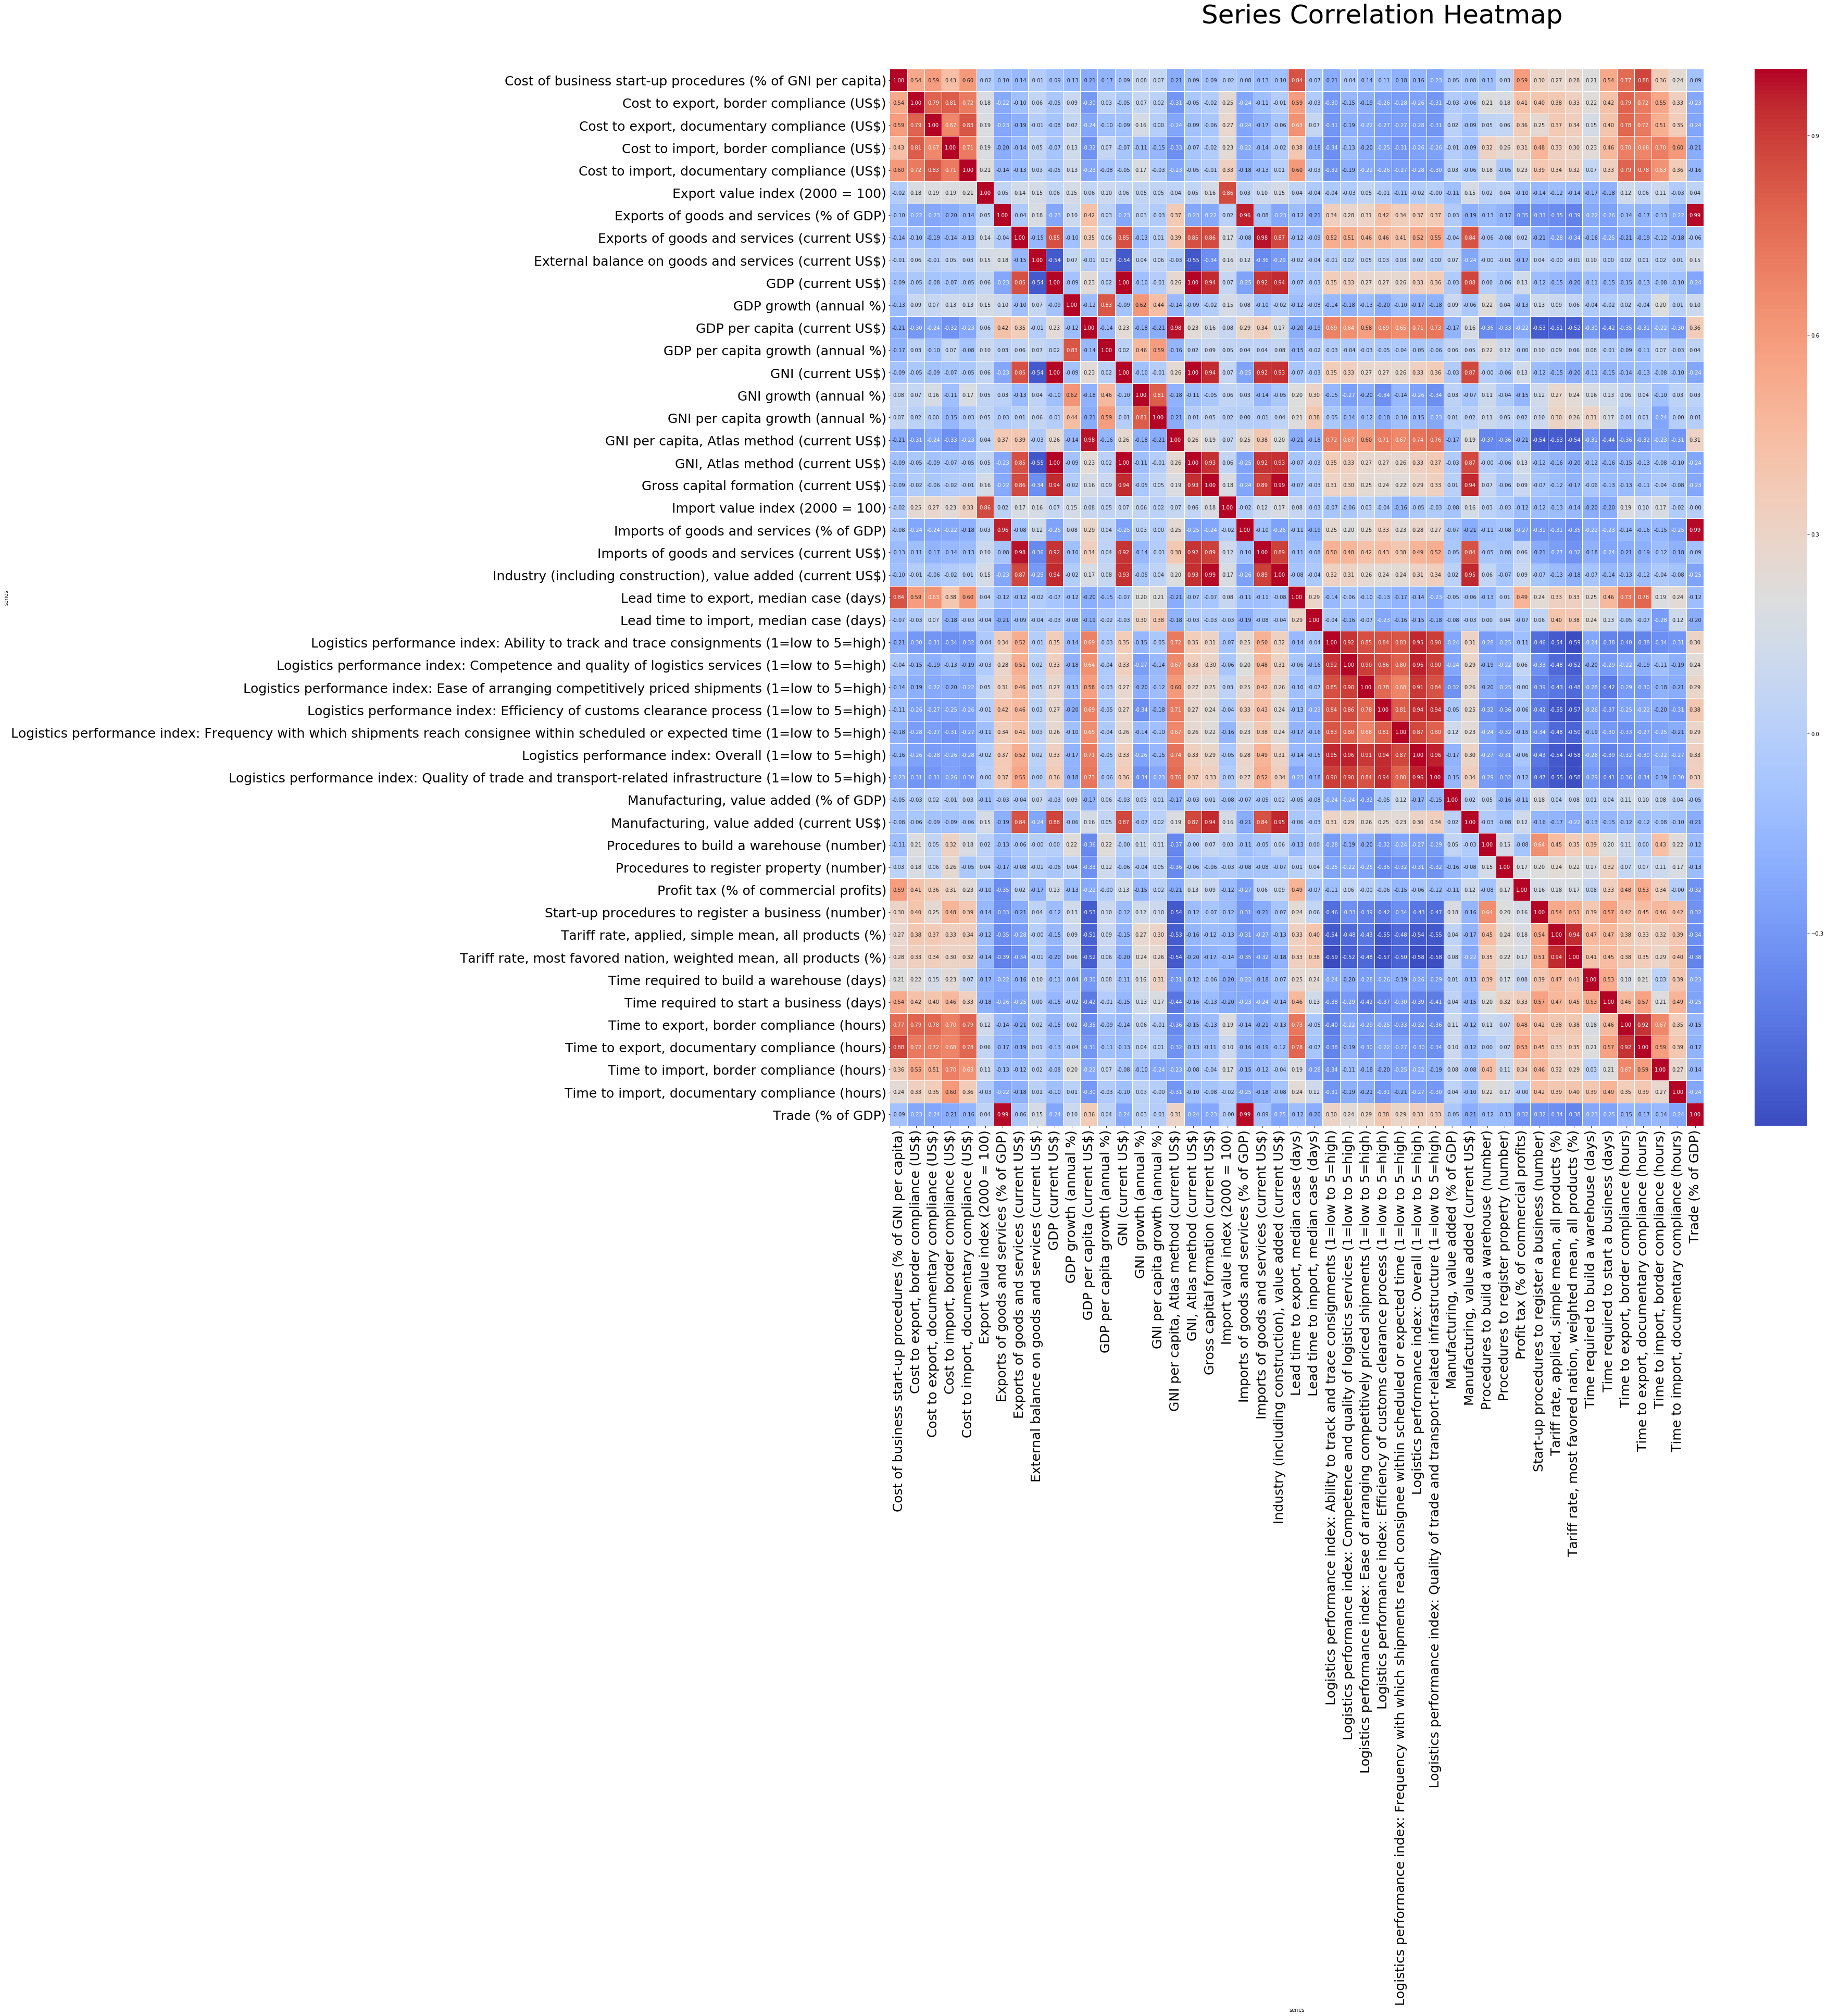

In [77]:
#Scaling
#StadardScaler is less effective in this case, and later would require more principal components
min_max_scaler = preprocessing.MinMaxScaler()

#Get unscaled values in an array from the unscaled df with the series pivoted
unscaled_values_array = series_pivoted.values

#The scaled values
scaled_values = min_max_scaler.fit_transform(unscaled_values_array)
x = scaled_values

#A dataframe visualization of the scaling on the series_pivoted
scaled_pivot_df = pd.DataFrame(scaled_values, columns = series_pivoted.columns, index = series_pivoted.index)

#Set the model criteria for the PCA
#Best practices is 85%-95% but we want to minimize the principal components as much as possible
#Whatever number of principal components where 75% of variance is retained
pca_model = PCA(.75)

#Get an array of the PCA values
pca_values = pca_model.fit_transform(scaled_values)

#Show number of components
print('Number of principal components:')
print(pca_model.n_components_)

#Show how much variance is explained with each PC
print('Variance explained with each PC:')
print(pca_model.explained_variance_ratio_)

#Show values array
print('PCA array values:')
print(pca_values)

#For Plotting Principal Components
x = pd.DataFrame(x, columns=series_pivoted.columns)


#Series Biplot
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = .75/(xs.max() - xs.min())
    scaley = .75/(ys.max() - ys.min())
    plt.figure(figsize=(18,18))
    plt.scatter(xs * scalex,ys * scaley,s=2)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.25)
        if labels is None:
            plt.text(coeff[i,0]* 1, coeff[i,1] * 1, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1, coeff[i,1] * 1, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1),fontsize = 40)
    plt.ylabel("PC{}".format(2), fontsize = 40)
    plt.title('PCA Mapping', fontsize = 40)
    plt.grid()

biplot(pca_values[:,0:2],np.transpose(pca_model.components_[0:2, :]),list(x.columns))
plt.show()

#Series Heatmap
ax = sns.heatmap(pca_model.components_, cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca_model.n_components_+1)],
                 xticklabels=list(x.columns),
                 cbar_kws={"orientation": "vertical"})
plt.title('PCA Heatmap')
plt.xticks(fontsize = 8)

ax.set_aspect("auto")

#Larger Heatmap
fig, ax = plt.subplots(figsize=(35, 35))
corr = scaled_pivot_df.corr()
heat_map = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.01)
fig.subplots_adjust(top=0.93)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
t= fig.suptitle('Series Correlation Heatmap', fontsize=50)

## I plan on implementing a series of subplots to display the trends of each feature for each country.
> - The issue that the legend is far too extensive at the moment, and compute cost would be very large
> - **I plan to resolve this soon**

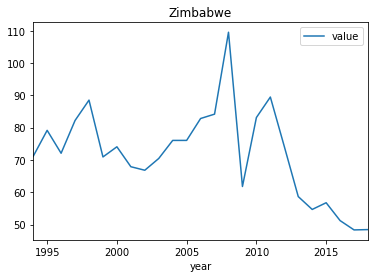

In [78]:
grouped_countries = scaled_pivot_df.reset_index().groupby(['country'])
group.plot(x = 'year', title = group_name).legend(bbox_to_anchor=(1,1))

### Loop will look like:
```
grouped_countries = scaled_pivot_df.reset_index().groupby(['country'])

for group_name, group in grouped_countries:
    
    group.plot(x = 'year', title = group_name).legend(bbox_to_anchor=(1,1))    
```
> **This could also be obtained using Matplotlib subplots, but I feel that it is important to experiment with different solutions**